In [4]:


# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)



In [5]:
##Just a sample datadet



np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)



**Principle Component**

In [6]:
X_centered = X - X.mean(axis=0) #We subtract the mean to center the data 
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:,0]
c2 = Vt.T[:,1]

Vt → The actual directions in which the data is spread (Principal Components!)

s → How much it is spread in those directions (like a measure of variance)

U, s, Vt are the svd cals to 

**Projecting DOWN to 'd' Dimensions**

In [7]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [8]:
X2D_using_svd = X2D


**NOW BY USING SCIKIT LEARN**

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [10]:
##Experienced Variance Ratio

##EVR is of each principle Component 
#The RATIO indicates the proportion of the datasets variance that lies along each principal Component

pca.explained_variance_ratio_

##This tell that 84.2% data variance lies along 1st PC and 14.6% along 2nd PC

array([0.84248607, 0.14631839])

In [11]:
##The foll code performes PCA w/o reducing the dimensionationaly, then computes the min no of dimensions
#required to maintain 95% of the training set variance 
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)



In [12]:


pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1




In [13]:
 ## To preserve variance to 95% 
 pca = PCA(n_components = 0.95)
 X_reduced = pca.fit_transform(X_train)

In [14]:
d

np.int64(154)

Saving figure explained_variance_plot


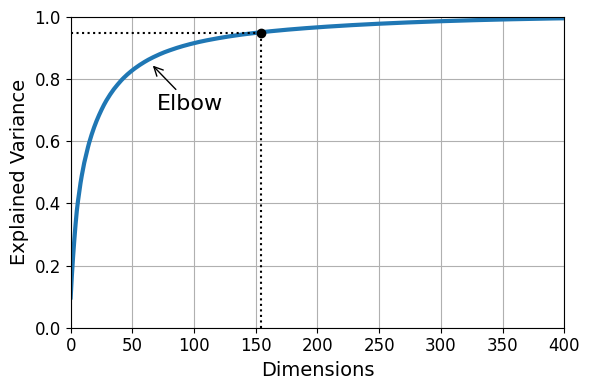

In [15]:
##Code copied from the book 
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
save_fig("explained_variance_plot")
plt.show()

In [ ]:
##Now we successfully reduced the dimension
# what if i wan decomt topress?

#Here comes **PCA for Compression** 

pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [17]:
##Randomised PCA is a faster version of PCA, especially for large datasets. 
# It uses a randomized algorithm to approximate the principal components.
## JUST SET THE svd_solver to "randomized"
rnd_pca = PCA(n_components = 154, svd_solver= "randomized")
X_reduced = rnd_pca.fit_transform(X_train)

In [18]:
#This is incremental PCA 
#If the dataset is very large it wont fit in the memory. soo its divided into mini-batches and PCA is performed

from sklearn.decomposition import IncrementalPCA
n_batches = 100
inc_pca = IncrementalPCA(n_components = 154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)
X_reduced = inc_pca.transform(X_train)

In [19]:
##Or instead we can use the memmap in Numpy


filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train



In [20]:


del X_mm



| PCA Type            | When to Use                                                                    | Best For                            |
| ------------------- | ------------------------------------------------------------------------------ | ----------------------------------- |
| **Standard PCA**    | When your dataset **fits in memory**                                           | Small/medium tabular data           |
| **Incremental PCA** | When your dataset is **too large to fit in memory**                            | Streaming, batch, or large datasets |
| **Randomized PCA**  | When you want **faster approximation** of PCA with **slight loss in accuracy** | Large datasets where speed matters  |
| **Kernel PCA**      | When data is **non-linear** and needs to be **transformed to higher dims**     | Non-linear problems (e.g., NLP, CV) |


In [21]:
#OR INSTEAD WE CAN USE THE memmap in Numpy
X_mm = np.memmap(filename, dtype = "float32", mode = "readonly", shape = (m,n))
batch_size = m 
inc_pca = IncrementalPCA(n_components=154, batch_size= batch_size)
inc_pca.fit(X_mm)

,n_components,154
,whiten,False
,copy,True
,batch_size,52500


**KERNEL PCA**

In [ ]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf" , gamma = 0.04)
X_reduced = rbf_pca.fit_transform(X)

**Selecting a kernel and tuning hyperparameters**

In [ ]:
##We can use Gridsearch to find the best hyperparameters for Kernel PCA
#But since PCA is unsupervised, 
# we need to combine it with a supervised model (like logistic regression, SVM, etc.) in a pipeline.

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
clf=Pipeline([
    ("kpca", KernelPCA(n_components=2)), #kpca being unsupervised,
    ("log_reg", LogisticRegression()) #A Pipeline ensures that:
                #KPCA is fit only on the training fold (not on the whole dataset).
])
param_grid = [{
    "kpca__gamma": np.linspace(0.03, 0.05, 10),
    "kpca__kernel": ["rbf", "sigmoid"]  #telling GridSearchCV to try both "rbf" and "sigmoid" kernels for KPCA.
}]
grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X_train,y_train)

In [ ]:
#What if i want to transform back to the original space?
#we specify the fit_inverse_transform=True 
rbf_pca = KernelPCA(n_components = 2, kernel = "rbf", gamma = 0.043,
                    fit_inverse_transform = True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

##Computing the reconstruction pre-image 
from sklearn.metrics import mean_squared_error
mean_squared_error(X, X_preimage)

#Non-Linear = Data lies on a curved surface

**Another D reduction : LLE**

In [ ]:
#Works for non-linear dimensionality reduction
#Even tho its non linear it preserves the relationship between the points 

from sklearn.manifold import LocallyLinearEmbedding
lle = LocallyLinearEmbedding(n_components=2, n_neighbors = 10)
X_reduced = lle.fit_transform(X)